In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
suppressPackageStartupMessages(suppressWarnings(library(Polychrome))) # color palette

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"


In [3]:
# set up directories
figure_dir <- file.path("..","figures")
if(!dir.exists(figure_dir)){
    dir.create(figure_dir)
}

## UMAP of morphological features

In [4]:
cell_umap_path <- file.path(paste0(
    "../","../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_all_cells.parquet"
))

cell_umap <- arrow::read_parquet(cell_umap_path)
print(paste0("Number of cells: ",nrow(cell_umap)))

[1] "Number of cells: 8318724"


In [5]:

# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)

In [6]:


# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
cell_umap$group <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cell_umap$group <- factor(cell_umap$group, levels = c("Control","Apoptosis", "Pyroptosis"))


In [7]:
# mutate the names of each treatment
cell_umap <- cell_umap %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Flagellin_1.000_ug_per_ml_DMSO_0.0_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_1.000_uM_DMSO_0.025_%' ~ "Thapsigargin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_10.000_nM_DMSO_0.025_%' ~ "Topotecan 10.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Thapsigargin_10.000_uM_DMSO_0.025_%' ~ "Thapsigargin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_20.000_nM_DMSO_0.025_%' ~ "Topotecan 20.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='Topotecan_5.000_nM_DMSO_0.025_%' ~ "Topotecan 5.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_ctr_0.0_0' ~ "Media ctr 0.0 0",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose =='media_ctr_0.0_0_Media_0.0_0' ~ "Media ctr 0.0 0"
    ))
    # replace Media ctr 0.0 0 with Media
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- gsub("Media ctr 0.0 0", "Media", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)


In [8]:
# split the oneb_Metadata_Treatment_Dose_Inhibitor_Dose into two columns by the " - " delimiter
cell_umap <- cell_umap %>%
    separate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose, c("inducer", "inhibitor"), sep = " - ", remove = FALSE)

In [9]:
# replace the inhibitor NA with Media
cell_umap$inhibitor <- ifelse(is.na(cell_umap$inhibitor), "Media", cell_umap$inhibitor)

In [10]:
# make the group_treatment column a factor
cell_umap$inducer <- factor(
    cell_umap$inducer, 
    levels = c(
        'Media',
        'DMSO 0.1%',

        'Flagellin 0.1 ug/ml',
        'Flagellin 1.0 ug/ml',

        'LPS 0.01 ug/ml',
        'LPS 0.1 ug/ml',
        'LPS 1.0 ug/ml',
        'LPS 10.0 ug/ml',
        'LPS 100.0 ug/ml',

        'LPS 1.0 ug/ml + Nigericin 1.0 uM',
        'LPS 1.0 ug/ml + Nigericin 3.0 uM',
        'LPS 1.0 ug/ml + Nigericin 10.0 uM',
        
        'LPS 100.0 ug/ml + Nigericin 1.0 uM',
        'LPS 100.0 ug/ml + Nigericin 3.0 uM',
        'LPS 100.0 ug/ml + Nigericin 10.0 uM',
        
        'H2O2 100.0 nM',
        'H2O2 100.0 uM',
        
        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',

        'Thapsigargin 1.0 uM',
        'Thapsigargin 10.0 uM',

        'Topotecan 5.0 nM',
        'Topotecan 10.0 nM',
        'Topotecan 20.0 nM'
    )
)

# make the group_treatment column a factor
cell_umap$inhibitor <- factor(
    cell_umap$inhibitor, 
    levels = c(
        'Media',
        'DMSO 0.025%',
        'DMSO 1.0%',
        
        'Disulfiram 0.1 uM',
        'Disulfiram 1.0 uM',
        'Disulfiram 2.5 uM',
        
        'Z-VAD-FMK 30.0 uM',
        'Z-VAD-FMK 100.0 uM'
    )
)

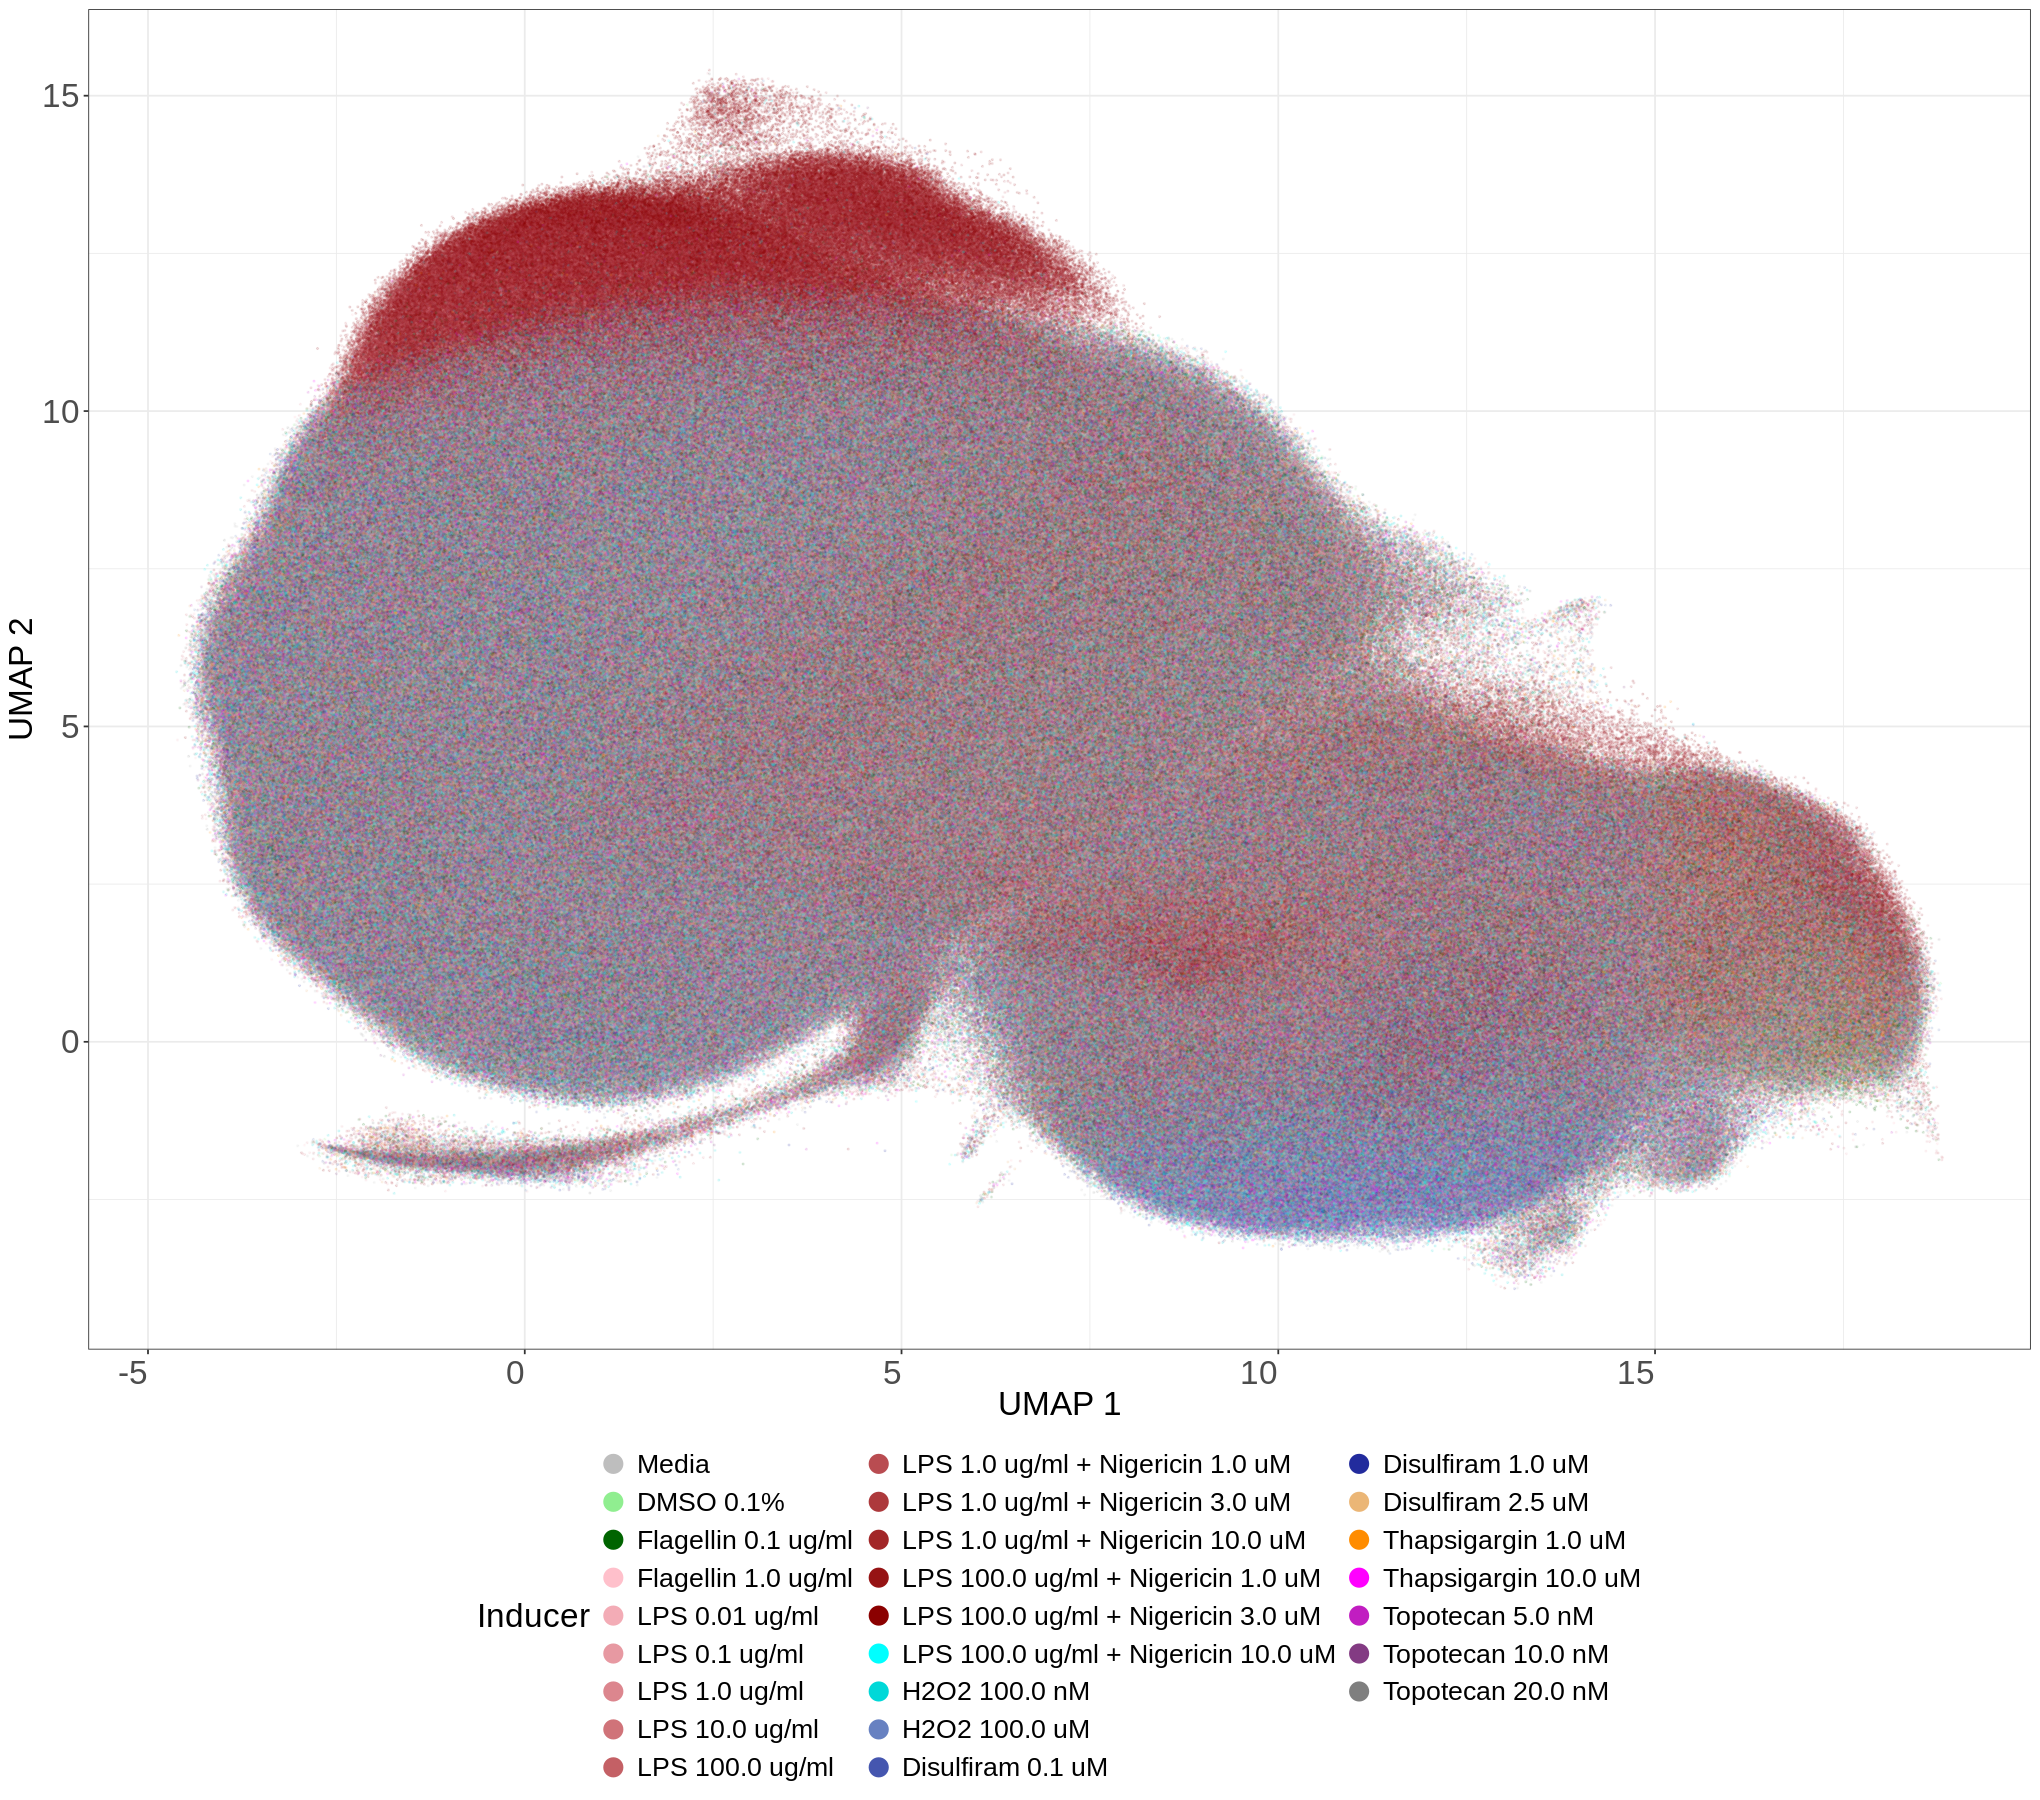

In [11]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
cell_umap <- cell_umap %>% sample_frac(1)
umap_plot_inducers <- (
    ggplot(cell_umap, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = inducer,
        ), 
        size = 0.25, 
        alpha = 0.1
    )
    + theme_bw()
    + figure_theme

    # rename legend title
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inducer",
        labels = c(
            'Media',
            'DMSO 0.1%',

            'Flagellin 0.1 ug/ml',
            'Flagellin 1.0 ug/ml',

            'LPS 0.01 ug/ml',
            'LPS 0.1 ug/ml',
            'LPS 1.0 ug/ml',
            'LPS 10.0 ug/ml',
            'LPS 100.0 ug/ml',

            'LPS 1.0 ug/ml + Nigericin 1.0 uM',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM',
            
            'LPS 100.0 ug/ml + Nigericin 1.0 uM',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM',
            'LPS 100.0 ug/ml + Nigericin 10.0 uM',
            
            'H2O2 100.0 nM',
            'H2O2 100.0 uM',
            
            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',

            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM',

            'Topotecan 5.0 nM',
            'Topotecan 10.0 nM',
            'Topotecan 20.0 nM'
        ),
        values = colors)

    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol = 3, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP 1",
        y = "UMAP 2"
    )   
)
umap_plot_inducers


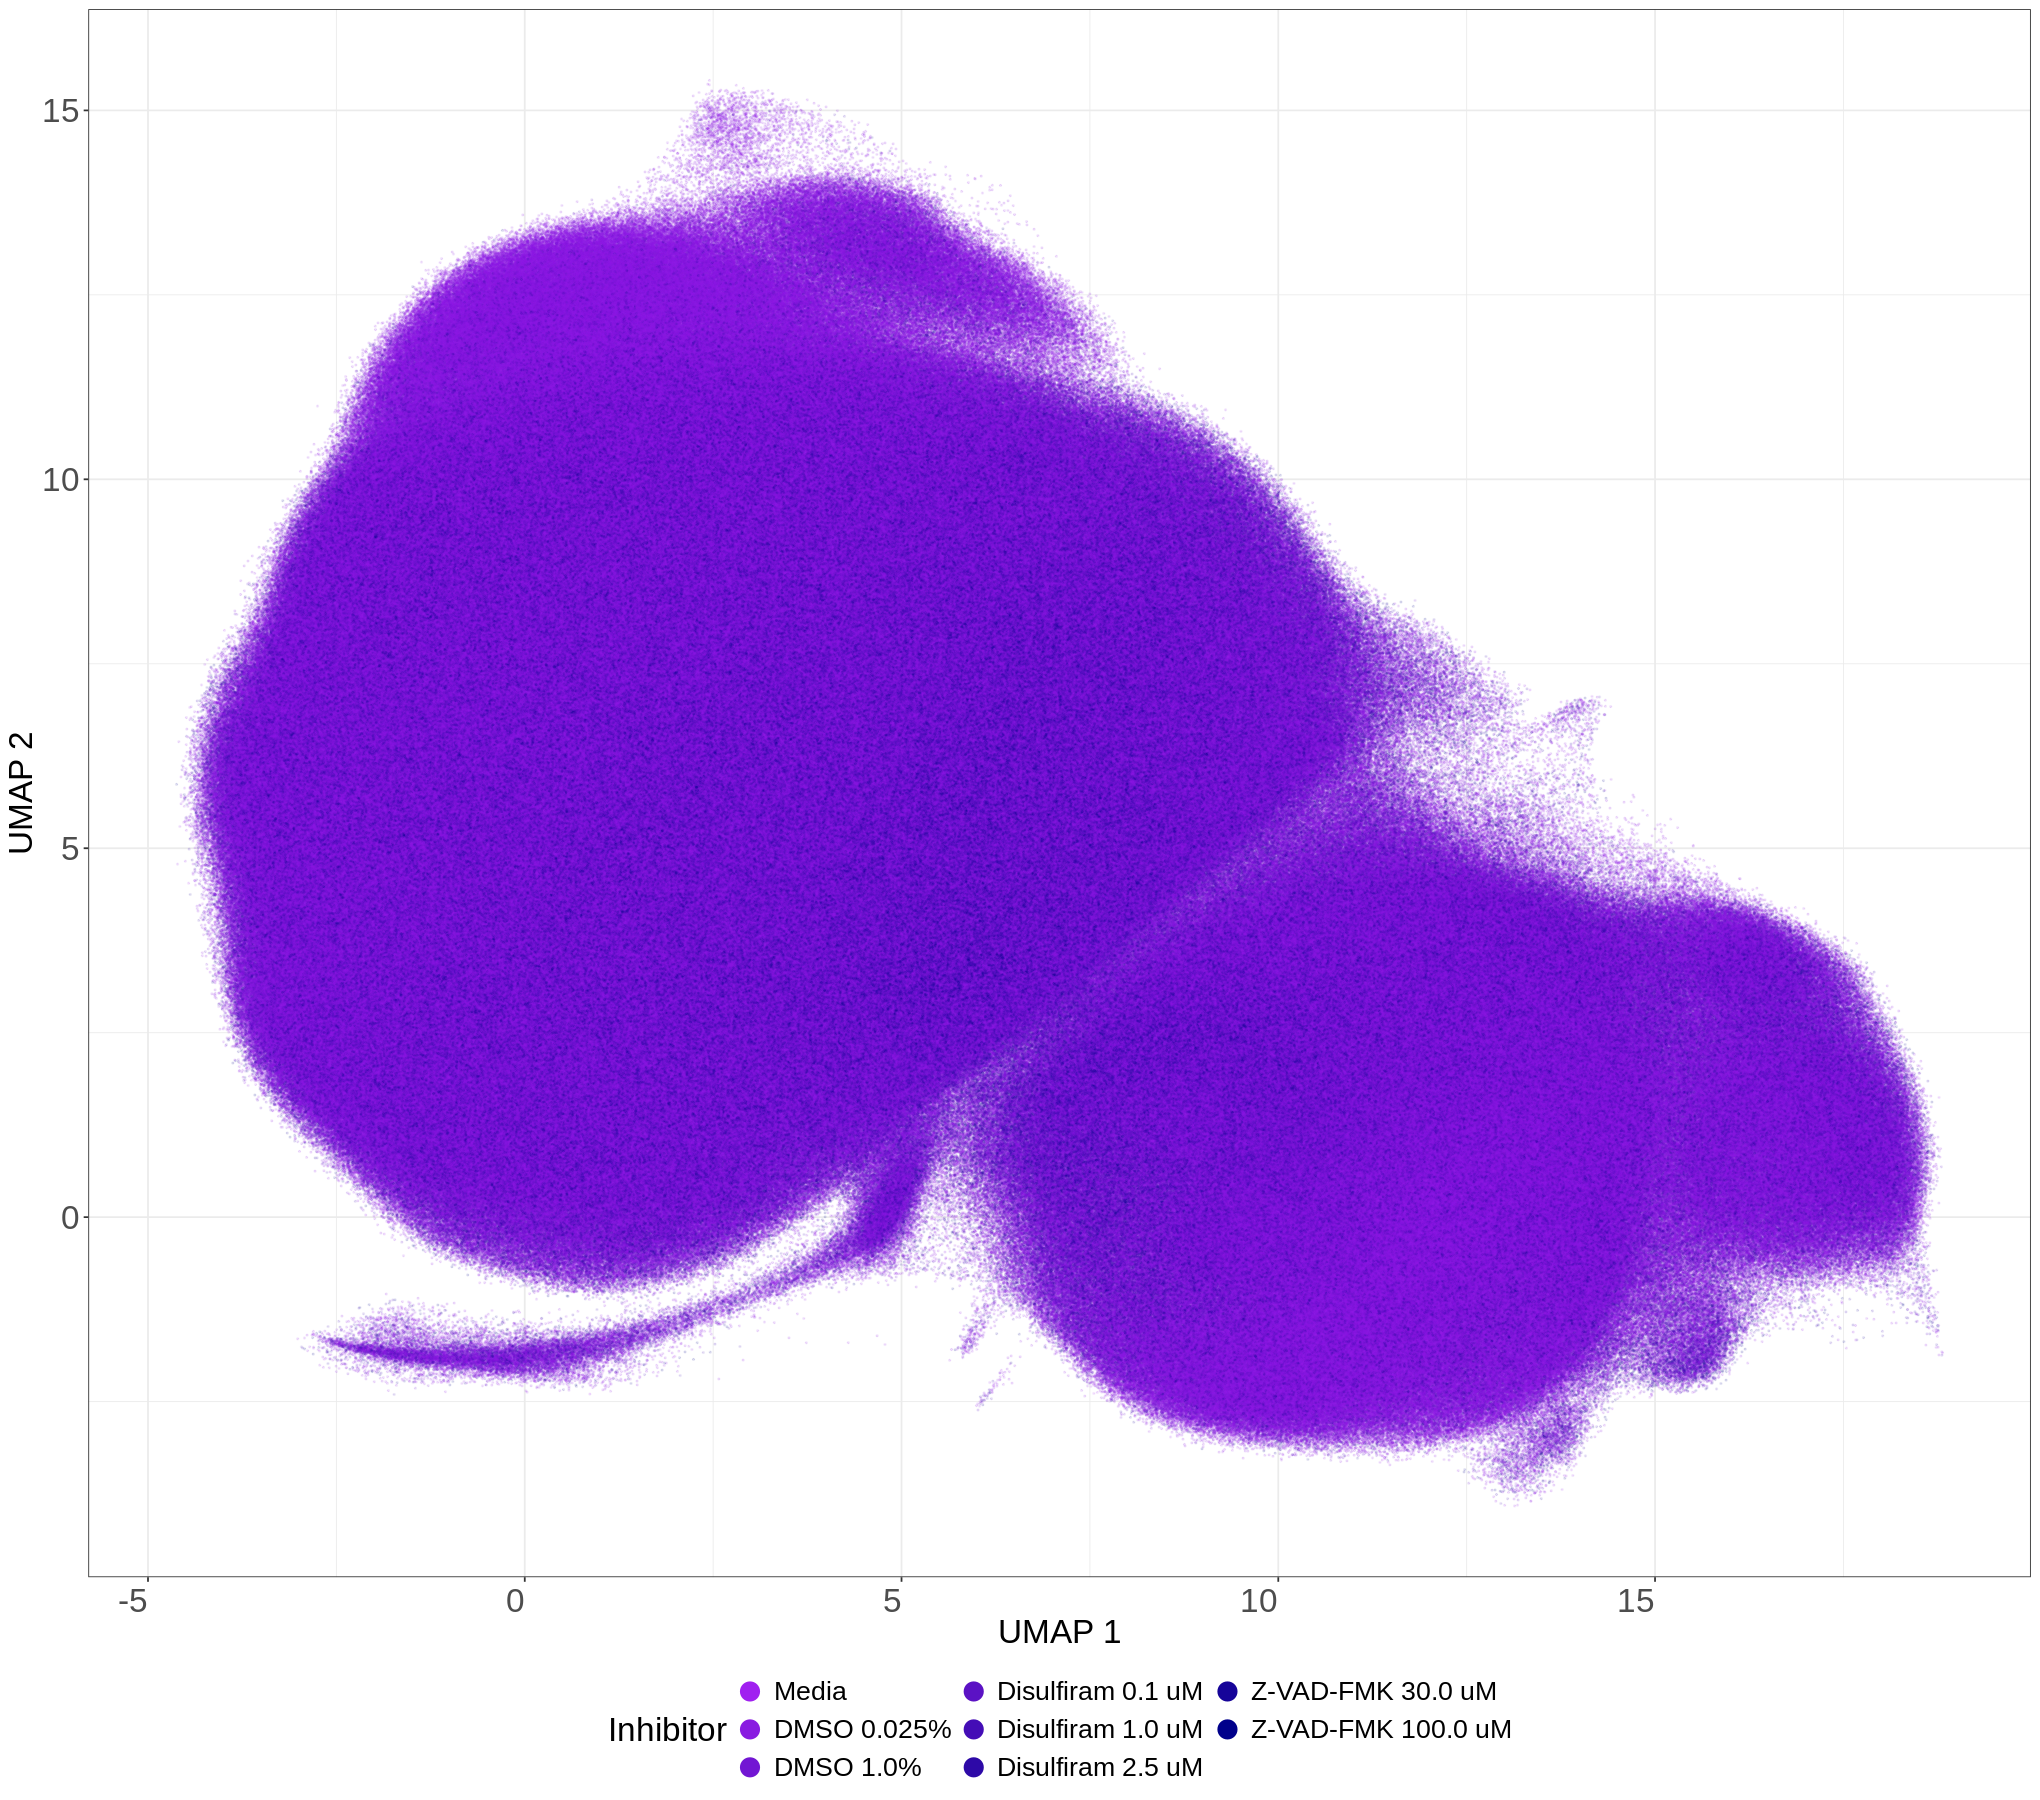

In [15]:
# set plot size 
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
umap_plot_inhibitors <- (
    ggplot(cell_umap, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = inhibitor,
        ), 
        size = 0.25, 
        alpha = 0.1
    )
    + theme_bw()
    + figure_theme

    # rename legend title
    + figure_theme
        + theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1))
            + theme(
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 20, hjust = 0.5))
    + scale_color_manual(
        name = "Inhibitor",
        labels = c(
            'Media',
            'DMSO 0.025%',
            'DMSO 1.0%',
            
            'Disulfiram 0.1 uM',
            'Disulfiram 1.0 uM',
            'Disulfiram 2.5 uM',
            
            'Z-VAD-FMK 30.0 uM',
            'Z-VAD-FMK 100.0 uM'
        ),
        values = colors_4)

    + theme(legend.position = "bottom")
    # set the legend columns to 4
    # change legend alpha 
    + guides(color = guide_legend(ncol = 3, override.aes = list(alpha = 1, size = 5)))
    + labs(
        x = "UMAP 1",
        y = "UMAP 2"
    )   
)
umap_plot_inhibitors


## Assemble the final plot

In [13]:
# layout <- c(
#     area(t=1, b=2, l=1, r=2), 
#     area(t=1, b=2, l=3, r=4),
# )

# # patch work the plots together
# # set plot size
# width <- 17
# height <- 20
# options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)

# figs5 <- (
#     wrap_elements(full = umap_plot_inducers)
#     + umap_plot_inhibitors

#     + plot_layout(design = layout, widths = c(8,8))
#     # make bottom plot not align
#     + plot_annotation(tag_levels = list(c("A", "B",))) & theme(plot.tag = element_text(size = 20))

# )
# ggsave(
#     filename = file.path("..","figures", "S5.png"),
#     plot = figs5,
#     width = width,
#     height = height,
#     units = "in",
#     dpi = 600
# )

# figs5


In [14]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Pop!_OS 22.04 LTS

Matrix products: default
BLAS/LAPACK: /home/lippincm/miniforge3/envs/Interstellar_R/lib/libopenblasp-r0.3.27.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Polychrome_1.5.1      ggvenn_0.1.10         forcats_1.0.0        
 [4] readr_2.1.5           tidyr_1.3.1           tibble_3.2.1         
 [7] tidyverse_1.3.2       VennDiagram_1.7.3     futile.logger_1.4.3  
[10] purrr_1.0.2           stringr_1.5.1         reshape2_1.4.4     